## Tsfresh Features Extraction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, auc, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# plotting
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import datetime

# setup
import os
os.chdir("/Users/adesai/mcadoo-failures-master/")
import glob
import feather
import random

import tsfresh
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

In [127]:
failures = pd.read_csv("failures.csv", index_col=0)
failures.head()

,Site,ID,Distance.to.turbine.south,Distance.to.turbine.north,Distance.to.terrain.feature.south,Distance.to.terrain.feature.north,Component.Manufacturer,Oil.Grease.Type,Failure,Individual.Damaged.Components,Starting.Date,Shutdown.Date,Operating.Hours.Before.Failure,Wallclock.Minutes.Before.Failure
1,McAdoo,1,35,35,1670,750,Moventas,Castrol A 320,no,na,7/2/08,NaN,24,NaN
2,McAdoo,2,35,35,1720,1020,Winergy,Castrol A 320,yes,HSS Bearing A,7/2/08,2/20/12,11,1912380.0
3,McAdoo,3,35,35,1700,1050,Winergy,Castrol A 320,no,na,7/2/08,NaN,24,NaN
4,McAdoo,4,35,36,2450,1160,Moventas,Castrol A 320,yes,HSS Bearing A,7/2/08,2/10/12,10,1897980.0
5,McAdoo,4,35,36,2450,1160,Moventas,Castrol X 320,yes,HSS Bearing A,2/10/12,4/29/13,2,639300.0


### Functions to find RMS and Kurtosis of aggregated data

In [128]:
def rms(data):
    rms = np.sqrt(np.sum([i**2 for i in data]))/len(data)
    return rms

def kurtosis(data):
    norm_data = data - np.mean(data)
    if sum(norm_data) == 0:
        return np.nan
    ku = np.mean(norm_data**4)/np.mean(norm_data**2)**2
    return ku

feats_1 = ['power', 'rotor_speed', 'gearbox_oil_temperature', 'gearbox_bearing_temperature', 'nacelle_temperature']

agg_dict = {i:['mean', np.std, 'min', 'max', rms, kurtosis] for i in feats_1}

### Function to prepare data

In [130]:
def limits(data):
    q1, q3= np.percentile(data,[25,75])
    iqr = q3 - q1 
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

def prep_df(turbine_ids):
    
    failure = pd.DataFrame(columns = ['turbine_id', 'failed'])
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
        temp_df.time = pd.to_datetime(temp_df.time)
        temp_df["Date"] = temp_df.time.dt.date
        
        shutdowns = list(failures['Shutdown.Date'][failures.ID == i])
        
        shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
        if(pd.notnull(shutdown_date)):
            temp_df = temp_df[temp_df.Date <= shutdown_date]
            failure = failure.append({'turbine_id': i, 'failed':1}, True)
        else:
            temp_df = temp_df[temp_df.Date <= pd.to_datetime("10-01-2013")]
            failure = failure.append({'turbine_id': i, 'failed':0}, True)
        
            
        df = df.append(temp_df)

    df = df.reset_index(drop = True)
    
    df = df.groupby(['turbine_id', 'Date']).agg(agg_dict)
    df.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df.columns.ravel()]
    df = df.reset_index()
    
    df.dropna(inplace = True)

    failure = failure.sort_values('turbine_id').reset_index(drop = True)
    return df, failure

### Importing all Winergy turbines data till 2014

In [131]:
# ids of failed turbines
hss_a = [2, 29, 65, 70, 84]
hss_b = [19, 38, 65, 82]
ims_a = [65]
ims_b = [11, 48, 65, 66, 79, 80]

failed = list(np.unique(hss_a + hss_b + ims_a + ims_b))

# ids of healthy turbines
healthy = [3, 5, 6, 24, 26, 30, 31, 34, 35, 36, 37, 53, 55, 59, 63, 64, 69, 73, 76, 77, 78, 81, 83,\
          85, 86, 92, 93, 94, 95, 97]

turbines = failed + healthy

In [132]:
df, failed = prep_df(turbines)

In [133]:
df.head()

,turbine_id,Date,power_mean,power_std,power_min,power_max,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,...,gearbox_bearing_temperature_min,gearbox_bearing_temperature_max,gearbox_bearing_temperature_rms,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_min,nacelle_temperature_max,nacelle_temperature_rms,nacelle_temperature_kurtosis
0,2,2008-12-01,619.066702,395.056823,-5.231667,1515.18665,78.602709,2.424308,15.721165,3.332425,...,29.000000,61.000000,6.203714,17.751497,14.151552,2.976744,10.175000,22.000000,1.550030,3.279908
2,2,2008-12-03,1484.094842,114.619552,988.966675,1530.72839,324.774613,18.289232,18.163873,0.942526,...,40.123333,61.818333,13.075673,15.122029,16.007857,1.701399,12.910000,18.200001,3.511942,1.987490
3,2,2008-12-04,537.489006,329.205906,84.135002,1386.19495,55.011703,2.264321,15.592327,2.644072,...,54.003334,60.490002,5.077943,1.863888,8.803779,3.734821,3.123333,18.756666,0.835057,2.880624
4,2,2008-12-05,238.391666,346.931946,-10.133333,1483.44995,42.590294,5.723599,9.626430,6.653666,...,32.000000,61.000000,5.122467,1.956948,9.509656,4.017372,2.000000,16.000000,1.047365,1.970233
6,2,2008-12-07,1215.260703,375.512536,405.088348,1531.02002,107.466308,2.117664,18.135503,0.523370,...,58.806667,62.000000,5.173721,3.147123,19.144952,2.727475,14.731667,23.863333,1.634265,1.691391


In [134]:
df.shape

(65033, 32)

In [135]:
df.columns

Index(['turbine_id', 'Date', 'power_mean', 'power_std', 'power_min',
       'power_max', 'power_rms', 'power_kurtosis', 'rotor_speed_mean',
       'rotor_speed_std', 'rotor_speed_min', 'rotor_speed_max',
       'rotor_speed_rms', 'rotor_speed_kurtosis',
       'gearbox_oil_temperature_mean', 'gearbox_oil_temperature_std',
       'gearbox_oil_temperature_min', 'gearbox_oil_temperature_max',
       'gearbox_oil_temperature_rms', 'gearbox_oil_temperature_kurtosis',
       'gearbox_bearing_temperature_mean', 'gearbox_bearing_temperature_std',
       'gearbox_bearing_temperature_min', 'gearbox_bearing_temperature_max',
       'gearbox_bearing_temperature_rms',
       'gearbox_bearing_temperature_kurtosis', 'nacelle_temperature_mean',
       'nacelle_temperature_std', 'nacelle_temperature_min',
       'nacelle_temperature_max', 'nacelle_temperature_rms',
       'nacelle_temperature_kurtosis'],
      dtype='object')

In [136]:
df.isnull().any().any()

False

In [137]:
failed.head()

,turbine_id,failed
0,2,1
1,3,0
2,5,0
3,6,0
4,11,1


## Tsfresh features Extrction

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import tree

In [138]:
tsfeats = {
 'variance_larger_than_standard_deviation': None,  # if varince is greater than std.deviation i.e sqrt(variance)
 'abs_energy': None, # the sum over the squared values
 'mean_abs_change': None, # mean of abs difference between subsequent time series values ~ lag 1
 'mean_change': None, # difference bw first and last value
 'mean_second_derivative_central': None, # mean value of a central approximation of the second derivative
 'median': None, # median
 'mean': None, # mean
 'standard_deviation': None, # std
 'variance': None, # variance
 'skewness': None, # skewness
 'kurtosis': None, # kurtosis
 'absolute_sum_of_changes': None, # sum of abs difference between subsequent time series values ~ lag 1
 'longest_strike_below_mean': None, # length of the longest consecutive subsequence in x that is smaller than the mean of x
 'longest_strike_above_mean': None, # length of the longest consecutive subsequence in x that is bigger than the mean of x
 'count_above_mean': None, # above mean counts
 'count_below_mean': None, # below mean counts
 'last_location_of_maximum': None, 
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'maximum': None,
 'minimum': None,
 'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'cid_ce': [{'normalize': True}, {'normalize': False}],   
 'symmetry_looking': [{'r': 0.0},
  {'r': 0.1},
  {'r': 0.2},
  {'r': 0.3},
  {'r': 0.4},
  {'r': 0.5},
  {'r': 0.6},
  {'r': 0.7},
  {'r': 0.8},
  {'r': 0.9}],
 'large_standard_deviation': [{'r': 0.1},
  {'r': 0.2},
  {'r': 0.3},
  {'r': 0.4},
  {'r': 0.5},
  {'r': 0.6},
  {'r': 0.7},
  {'r': 0.8},
  {'r': 0.9}],
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'median', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'partial_autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'number_cwt_peaks': [{'n': 1}, {'n': 5}],
 'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
 'binned_entropy': [{'max_bins': 10}],
 'index_mass_quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'}],
 'friedrich_coefficients': [{'coeff': 0, 'm': 3, 'r': 30},
  {'coeff': 1, 'm': 3, 'r': 30},
  {'coeff': 2, 'm': 3, 'r': 30},
  {'coeff': 3, 'm': 3, 'r': 30}],
 'max_langevin_fixed_point': [{'m': 3, 'r': 30}],
 'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'var'}],
 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}],
 'fft_coefficient': [{'coeff': 0, 'attr': 'real'},
  {'coeff': 1, 'attr': 'real'},
  {'coeff': 2, 'attr': 'real'},
  {'coeff': 3, 'attr': 'real'},
  {'coeff': 4, 'attr': 'real'},
  {'coeff': 5, 'attr': 'real'},
  {'coeff': 6, 'attr': 'real'},
  {'coeff': 7, 'attr': 'real'},
  {'coeff': 8, 'attr': 'real'},
  {'coeff': 9, 'attr': 'real'},
  {'coeff': 10, 'attr': 'real'},
  {'coeff': 11, 'attr': 'real'},
  {'coeff': 12, 'attr': 'real'},
  {'coeff': 13, 'attr': 'real'},
  {'coeff': 14, 'attr': 'real'},
  {'coeff': 15, 'attr': 'real'},
  {'coeff': 16, 'attr': 'real'},
  {'coeff': 17, 'attr': 'real'},
  {'coeff': 18, 'attr': 'real'},
  {'coeff': 19, 'attr': 'real'},
  {'coeff': 20, 'attr': 'real'},
  {'coeff': 21, 'attr': 'real'},
  {'coeff': 22, 'attr': 'real'},
  {'coeff': 23, 'attr': 'real'},
  {'coeff': 24, 'attr': 'real'},
  {'coeff': 25, 'attr': 'real'},
  {'coeff': 26, 'attr': 'real'},
  {'coeff': 27, 'attr': 'real'},
  {'coeff': 28, 'attr': 'real'},
  {'coeff': 29, 'attr': 'real'},
  {'coeff': 30, 'attr': 'real'},
  {'coeff': 31, 'attr': 'real'},
  {'coeff': 32, 'attr': 'real'},
  {'coeff': 33, 'attr': 'real'},
  {'coeff': 34, 'attr': 'real'},
  {'coeff': 35, 'attr': 'real'},
  {'coeff': 36, 'attr': 'real'},
  {'coeff': 37, 'attr': 'real'},
  {'coeff': 38, 'attr': 'real'},
  {'coeff': 39, 'attr': 'real'},
  {'coeff': 40, 'attr': 'real'},
  {'coeff': 41, 'attr': 'real'},
  {'coeff': 42, 'attr': 'real'},
  {'coeff': 43, 'attr': 'real'},
  {'coeff': 44, 'attr': 'real'},
  {'coeff': 45, 'attr': 'real'},
  {'coeff': 46, 'attr': 'real'},
  {'coeff': 47, 'attr': 'real'},
  {'coeff': 48, 'attr': 'real'},
  {'coeff': 49, 'attr': 'real'},
  {'coeff': 50, 'attr': 'real'},
  {'coeff': 51, 'attr': 'real'},
  {'coeff': 52, 'attr': 'real'},
  {'coeff': 53, 'attr': 'real'},
  {'coeff': 54, 'attr': 'real'},
  {'coeff': 55, 'attr': 'real'},
  {'coeff': 56, 'attr': 'real'},
  {'coeff': 57, 'attr': 'real'},
  {'coeff': 58, 'attr': 'real'},
  {'coeff': 59, 'attr': 'real'},
  {'coeff': 60, 'attr': 'real'},
  {'coeff': 61, 'attr': 'real'},
  {'coeff': 62, 'attr': 'real'},
  {'coeff': 63, 'attr': 'real'},
  {'coeff': 64, 'attr': 'real'},
  {'coeff': 65, 'attr': 'real'},
  {'coeff': 66, 'attr': 'real'},
  {'coeff': 67, 'attr': 'real'},
  {'coeff': 68, 'attr': 'real'},
  {'coeff': 69, 'attr': 'real'},
  {'coeff': 70, 'attr': 'real'},
  {'coeff': 71, 'attr': 'real'},
  {'coeff': 72, 'attr': 'real'},
  {'coeff': 73, 'attr': 'real'},
  {'coeff': 74, 'attr': 'real'},
  {'coeff': 75, 'attr': 'real'},
  {'coeff': 76, 'attr': 'real'},
  {'coeff': 77, 'attr': 'real'},
  {'coeff': 78, 'attr': 'real'},
  {'coeff': 79, 'attr': 'real'},
  {'coeff': 80, 'attr': 'real'},
  {'coeff': 81, 'attr': 'real'},
  {'coeff': 82, 'attr': 'real'},
  {'coeff': 83, 'attr': 'real'},
  {'coeff': 84, 'attr': 'real'},
  {'coeff': 85, 'attr': 'real'},
  {'coeff': 86, 'attr': 'real'},
  {'coeff': 87, 'attr': 'real'},
  {'coeff': 88, 'attr': 'real'},
  {'coeff': 89, 'attr': 'real'},
  {'coeff': 90, 'attr': 'real'},
  {'coeff': 91, 'attr': 'real'},
  {'coeff': 92, 'attr': 'real'},
  {'coeff': 93, 'attr': 'real'},
  {'coeff': 94, 'attr': 'real'},
  {'coeff': 95, 'attr': 'real'},
  {'coeff': 96, 'attr': 'real'},
  {'coeff': 97, 'attr': 'real'},
  {'coeff': 98, 'attr': 'real'},
  {'coeff': 99, 'attr': 'real'},
  {'coeff': 0, 'attr': 'imag'},
  {'coeff': 1, 'attr': 'imag'},
  {'coeff': 2, 'attr': 'imag'},
  {'coeff': 3, 'attr': 'imag'},
  {'coeff': 4, 'attr': 'imag'},
  {'coeff': 5, 'attr': 'imag'},
  {'coeff': 6, 'attr': 'imag'},
  {'coeff': 7, 'attr': 'imag'},
  {'coeff': 8, 'attr': 'imag'},
  {'coeff': 9, 'attr': 'imag'},
  {'coeff': 10, 'attr': 'imag'},
  {'coeff': 11, 'attr': 'imag'},
  {'coeff': 12, 'attr': 'imag'},
  {'coeff': 13, 'attr': 'imag'},
  {'coeff': 14, 'attr': 'imag'},
  {'coeff': 15, 'attr': 'imag'},
  {'coeff': 16, 'attr': 'imag'},
  {'coeff': 17, 'attr': 'imag'},
  {'coeff': 18, 'attr': 'imag'},
  {'coeff': 19, 'attr': 'imag'},
  {'coeff': 20, 'attr': 'imag'},
  {'coeff': 21, 'attr': 'imag'},
  {'coeff': 22, 'attr': 'imag'},
  {'coeff': 23, 'attr': 'imag'},
  {'coeff': 24, 'attr': 'imag'},
  {'coeff': 25, 'attr': 'imag'},
  {'coeff': 26, 'attr': 'imag'},
  {'coeff': 27, 'attr': 'imag'},
  {'coeff': 28, 'attr': 'imag'},
  {'coeff': 29, 'attr': 'imag'},
  {'coeff': 30, 'attr': 'imag'},
  {'coeff': 31, 'attr': 'imag'},
  {'coeff': 32, 'attr': 'imag'},
  {'coeff': 33, 'attr': 'imag'},
  {'coeff': 34, 'attr': 'imag'},
  {'coeff': 35, 'attr': 'imag'},
  {'coeff': 36, 'attr': 'imag'},
  {'coeff': 37, 'attr': 'imag'},
  {'coeff': 38, 'attr': 'imag'},
  {'coeff': 39, 'attr': 'imag'},
  {'coeff': 40, 'attr': 'imag'},
  {'coeff': 41, 'attr': 'imag'},
  {'coeff': 42, 'attr': 'imag'},
  {'coeff': 43, 'attr': 'imag'},
  {'coeff': 44, 'attr': 'imag'},
  {'coeff': 45, 'attr': 'imag'},
  {'coeff': 46, 'attr': 'imag'},
  {'coeff': 47, 'attr': 'imag'},
  {'coeff': 48, 'attr': 'imag'},
  {'coeff': 49, 'attr': 'imag'},
  {'coeff': 50, 'attr': 'imag'},
  {'coeff': 51, 'attr': 'imag'},
  {'coeff': 52, 'attr': 'imag'},
  {'coeff': 53, 'attr': 'imag'},
  {'coeff': 54, 'attr': 'imag'},
  {'coeff': 55, 'attr': 'imag'},
  {'coeff': 56, 'attr': 'imag'},
  {'coeff': 57, 'attr': 'imag'},
  {'coeff': 58, 'attr': 'imag'},
  {'coeff': 59, 'attr': 'imag'},
  {'coeff': 60, 'attr': 'imag'},
  {'coeff': 61, 'attr': 'imag'},
  {'coeff': 62, 'attr': 'imag'},
  {'coeff': 63, 'attr': 'imag'},
  {'coeff': 64, 'attr': 'imag'},
  {'coeff': 65, 'attr': 'imag'},
  {'coeff': 66, 'attr': 'imag'},
  {'coeff': 67, 'attr': 'imag'},
  {'coeff': 68, 'attr': 'imag'},
  {'coeff': 69, 'attr': 'imag'},
  {'coeff': 70, 'attr': 'imag'},
  {'coeff': 71, 'attr': 'imag'},
  {'coeff': 72, 'attr': 'imag'},
  {'coeff': 73, 'attr': 'imag'},
  {'coeff': 74, 'attr': 'imag'},
  {'coeff': 75, 'attr': 'imag'},
  {'coeff': 76, 'attr': 'imag'},
  {'coeff': 77, 'attr': 'imag'},
  {'coeff': 78, 'attr': 'imag'},
  {'coeff': 79, 'attr': 'imag'},
  {'coeff': 80, 'attr': 'imag'},
  {'coeff': 81, 'attr': 'imag'},
  {'coeff': 82, 'attr': 'imag'},
  {'coeff': 83, 'attr': 'imag'},
  {'coeff': 84, 'attr': 'imag'},
  {'coeff': 85, 'attr': 'imag'},
  {'coeff': 86, 'attr': 'imag'},
  {'coeff': 87, 'attr': 'imag'},
  {'coeff': 88, 'attr': 'imag'},
  {'coeff': 89, 'attr': 'imag'},
  {'coeff': 90, 'attr': 'imag'},
  {'coeff': 91, 'attr': 'imag'},
  {'coeff': 92, 'attr': 'imag'},
  {'coeff': 93, 'attr': 'imag'},
  {'coeff': 94, 'attr': 'imag'},
  {'coeff': 95, 'attr': 'imag'},
  {'coeff': 96, 'attr': 'imag'},
  {'coeff': 97, 'attr': 'imag'},
  {'coeff': 98, 'attr': 'imag'},
  {'coeff': 99, 'attr': 'imag'},
  {'coeff': 0, 'attr': 'abs'},
  {'coeff': 1, 'attr': 'abs'},
  {'coeff': 2, 'attr': 'abs'},
  {'coeff': 3, 'attr': 'abs'},
  {'coeff': 4, 'attr': 'abs'},
  {'coeff': 5, 'attr': 'abs'},
  {'coeff': 6, 'attr': 'abs'},
  {'coeff': 7, 'attr': 'abs'},
  {'coeff': 8, 'attr': 'abs'},
  {'coeff': 9, 'attr': 'abs'},
  {'coeff': 10, 'attr': 'abs'},
  {'coeff': 11, 'attr': 'abs'},
  {'coeff': 12, 'attr': 'abs'},
  {'coeff': 13, 'attr': 'abs'},
  {'coeff': 14, 'attr': 'abs'},
  {'coeff': 15, 'attr': 'abs'},
  {'coeff': 16, 'attr': 'abs'},
  {'coeff': 17, 'attr': 'abs'},
  {'coeff': 18, 'attr': 'abs'},
  {'coeff': 19, 'attr': 'abs'},
  {'coeff': 20, 'attr': 'abs'},
  {'coeff': 21, 'attr': 'abs'},
  {'coeff': 22, 'attr': 'abs'},
  {'coeff': 23, 'attr': 'abs'},
  {'coeff': 24, 'attr': 'abs'},
  {'coeff': 25, 'attr': 'abs'},
  {'coeff': 26, 'attr': 'abs'},
  {'coeff': 27, 'attr': 'abs'},
  {'coeff': 28, 'attr': 'abs'},
  {'coeff': 29, 'attr': 'abs'},
  {'coeff': 30, 'attr': 'abs'},
  {'coeff': 31, 'attr': 'abs'},
  {'coeff': 32, 'attr': 'abs'},
  {'coeff': 33, 'attr': 'abs'},
  {'coeff': 34, 'attr': 'abs'},
  {'coeff': 35, 'attr': 'abs'},
  {'coeff': 36, 'attr': 'abs'},
  {'coeff': 37, 'attr': 'abs'},
  {'coeff': 38, 'attr': 'abs'},
  {'coeff': 39, 'attr': 'abs'},
  {'coeff': 40, 'attr': 'abs'},
  {'coeff': 41, 'attr': 'abs'},
  {'coeff': 42, 'attr': 'abs'},
  {'coeff': 43, 'attr': 'abs'},
  {'coeff': 44, 'attr': 'abs'},
  {'coeff': 45, 'attr': 'abs'},
  {'coeff': 46, 'attr': 'abs'},
  {'coeff': 47, 'attr': 'abs'},
  {'coeff': 48, 'attr': 'abs'},
  {'coeff': 49, 'attr': 'abs'},
  {'coeff': 50, 'attr': 'abs'},
  {'coeff': 51, 'attr': 'abs'},
  {'coeff': 52, 'attr': 'abs'},
  {'coeff': 53, 'attr': 'abs'},
  {'coeff': 54, 'attr': 'abs'},
  {'coeff': 55, 'attr': 'abs'},
  {'coeff': 56, 'attr': 'abs'},
  {'coeff': 57, 'attr': 'abs'},
  {'coeff': 58, 'attr': 'abs'},
  {'coeff': 59, 'attr': 'abs'},
  {'coeff': 60, 'attr': 'abs'},
  {'coeff': 61, 'attr': 'abs'},
  {'coeff': 62, 'attr': 'abs'},
  {'coeff': 63, 'attr': 'abs'},
  {'coeff': 64, 'attr': 'abs'},
  {'coeff': 65, 'attr': 'abs'},
  {'coeff': 66, 'attr': 'abs'},
  {'coeff': 67, 'attr': 'abs'},
  {'coeff': 68, 'attr': 'abs'},
  {'coeff': 69, 'attr': 'abs'},
  {'coeff': 70, 'attr': 'abs'},
  {'coeff': 71, 'attr': 'abs'},
  {'coeff': 72, 'attr': 'abs'},
  {'coeff': 73, 'attr': 'abs'},
  {'coeff': 74, 'attr': 'abs'},
  {'coeff': 75, 'attr': 'abs'},
  {'coeff': 76, 'attr': 'abs'},
  {'coeff': 77, 'attr': 'abs'},
  {'coeff': 78, 'attr': 'abs'},
  {'coeff': 79, 'attr': 'abs'},
  {'coeff': 80, 'attr': 'abs'},
  {'coeff': 81, 'attr': 'abs'},
  {'coeff': 82, 'attr': 'abs'},
  {'coeff': 83, 'attr': 'abs'},
  {'coeff': 84, 'attr': 'abs'},
  {'coeff': 85, 'attr': 'abs'},
  {'coeff': 86, 'attr': 'abs'},
  {'coeff': 87, 'attr': 'abs'},
  {'coeff': 88, 'attr': 'abs'},
  {'coeff': 89, 'attr': 'abs'},
  {'coeff': 90, 'attr': 'abs'},
  {'coeff': 91, 'attr': 'abs'},
  {'coeff': 92, 'attr': 'abs'},
  {'coeff': 93, 'attr': 'abs'},
  {'coeff': 94, 'attr': 'abs'},
  {'coeff': 95, 'attr': 'abs'},
  {'coeff': 96, 'attr': 'abs'},
  {'coeff': 97, 'attr': 'abs'},
  {'coeff': 98, 'attr': 'abs'},
  {'coeff': 99, 'attr': 'abs'},
  {'coeff': 0, 'attr': 'angle'},
  {'coeff': 1, 'attr': 'angle'},
  {'coeff': 2, 'attr': 'angle'},
  {'coeff': 3, 'attr': 'angle'},
  {'coeff': 4, 'attr': 'angle'},
  {'coeff': 5, 'attr': 'angle'},
  {'coeff': 6, 'attr': 'angle'},
  {'coeff': 7, 'attr': 'angle'},
  {'coeff': 8, 'attr': 'angle'},
  {'coeff': 9, 'attr': 'angle'},
  {'coeff': 10, 'attr': 'angle'},
  {'coeff': 11, 'attr': 'angle'},
  {'coeff': 12, 'attr': 'angle'},
  {'coeff': 13, 'attr': 'angle'},
  {'coeff': 14, 'attr': 'angle'},
  {'coeff': 15, 'attr': 'angle'},
  {'coeff': 16, 'attr': 'angle'},
  {'coeff': 17, 'attr': 'angle'},
  {'coeff': 18, 'attr': 'angle'},
  {'coeff': 19, 'attr': 'angle'},
  {'coeff': 20, 'attr': 'angle'},
  {'coeff': 21, 'attr': 'angle'},
  {'coeff': 22, 'attr': 'angle'},
  {'coeff': 23, 'attr': 'angle'},
  {'coeff': 24, 'attr': 'angle'},
  {'coeff': 25, 'attr': 'angle'},
  {'coeff': 26, 'attr': 'angle'},
  {'coeff': 27, 'attr': 'angle'},
  {'coeff': 28, 'attr': 'angle'},
  {'coeff': 29, 'attr': 'angle'},
  {'coeff': 30, 'attr': 'angle'},
  {'coeff': 31, 'attr': 'angle'},
  {'coeff': 32, 'attr': 'angle'},
  {'coeff': 33, 'attr': 'angle'},
  {'coeff': 34, 'attr': 'angle'},
  {'coeff': 35, 'attr': 'angle'},
  {'coeff': 36, 'attr': 'angle'},
  {'coeff': 37, 'attr': 'angle'},
  {'coeff': 38, 'attr': 'angle'},
  {'coeff': 39, 'attr': 'angle'},
  {'coeff': 40, 'attr': 'angle'},
  {'coeff': 41, 'attr': 'angle'},
  {'coeff': 42, 'attr': 'angle'},
  {'coeff': 43, 'attr': 'angle'},
  {'coeff': 44, 'attr': 'angle'},
  {'coeff': 45, 'attr': 'angle'},
  {'coeff': 46, 'attr': 'angle'},
  {'coeff': 47, 'attr': 'angle'},
  {'coeff': 48, 'attr': 'angle'},
  {'coeff': 49, 'attr': 'angle'},
  {'coeff': 50, 'attr': 'angle'},
  {'coeff': 51, 'attr': 'angle'},
  {'coeff': 52, 'attr': 'angle'},
  {'coeff': 53, 'attr': 'angle'},
  {'coeff': 54, 'attr': 'angle'},
  {'coeff': 55, 'attr': 'angle'},
  {'coeff': 56, 'attr': 'angle'},
  {'coeff': 57, 'attr': 'angle'},
  {'coeff': 58, 'attr': 'angle'},
  {'coeff': 59, 'attr': 'angle'},
  {'coeff': 60, 'attr': 'angle'},
  {'coeff': 61, 'attr': 'angle'},
  {'coeff': 62, 'attr': 'angle'},
  {'coeff': 63, 'attr': 'angle'},
  {'coeff': 64, 'attr': 'angle'},
  {'coeff': 65, 'attr': 'angle'},
  {'coeff': 66, 'attr': 'angle'},
  {'coeff': 67, 'attr': 'angle'},
  {'coeff': 68, 'attr': 'angle'},
  {'coeff': 69, 'attr': 'angle'},
  {'coeff': 70, 'attr': 'angle'},
  {'coeff': 71, 'attr': 'angle'},
  {'coeff': 72, 'attr': 'angle'},
  {'coeff': 73, 'attr': 'angle'},
  {'coeff': 74, 'attr': 'angle'},
  {'coeff': 75, 'attr': 'angle'},
  {'coeff': 76, 'attr': 'angle'},
  {'coeff': 77, 'attr': 'angle'},
  {'coeff': 78, 'attr': 'angle'},
  {'coeff': 79, 'attr': 'angle'},
  {'coeff': 80, 'attr': 'angle'},
  {'coeff': 81, 'attr': 'angle'},
  {'coeff': 82, 'attr': 'angle'},
  {'coeff': 83, 'attr': 'angle'},
  {'coeff': 84, 'attr': 'angle'},
  {'coeff': 85, 'attr': 'angle'},
  {'coeff': 86, 'attr': 'angle'},
  {'coeff': 87, 'attr': 'angle'},
  {'coeff': 88, 'attr': 'angle'},
  {'coeff': 89, 'attr': 'angle'},
  {'coeff': 90, 'attr': 'angle'},
  {'coeff': 91, 'attr': 'angle'},
  {'coeff': 92, 'attr': 'angle'},
  {'coeff': 93, 'attr': 'angle'},
  {'coeff': 94, 'attr': 'angle'},
  {'coeff': 95, 'attr': 'angle'},
  {'coeff': 96, 'attr': 'angle'},
  {'coeff': 97, 'attr': 'angle'},
  {'coeff': 98, 'attr': 'angle'},
  {'coeff': 99, 'attr': 'angle'}],
 'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}]   
}

In [139]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

Feature Extraction: 100%|██████████| 10/10 [02:11<00:00, 13.14s/it]


In [140]:
feat_df.shape

(43, 18990)

In [141]:
# drop columns that do not have any variance
cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
# drop columns that contain nan
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

len(cols)

18261

In [142]:
x = feat_df[cols]
print(x.shape)

y = failed.failed
y = y.astype('int')
print(y.shape)

(43, 18261)
(43,)


In [143]:
x.head()

variable,gearbox_bearing_temperature_kurtosis__abs_energy,gearbox_bearing_temperature_kurtosis__absolute_sum_of_changes,"gearbox_bearing_temperature_kurtosis__agg_autocorrelation__f_agg_""mean""__maxlag_40","gearbox_bearing_temperature_kurtosis__agg_autocorrelation__f_agg_""median""__maxlag_40","gearbox_bearing_temperature_kurtosis__agg_autocorrelation__f_agg_""var""__maxlag_40","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,rotor_speed_std__ratio_beyond_r_sigma__r_1.5,rotor_speed_std__ratio_beyond_r_sigma__r_2,rotor_speed_std__ratio_beyond_r_sigma__r_2.5,rotor_speed_std__ratio_beyond_r_sigma__r_3,rotor_speed_std__skewness,rotor_speed_std__standard_deviation,rotor_speed_std__time_reversal_asymmetry_statistic__lag_1,rotor_speed_std__time_reversal_asymmetry_statistic__lag_2,rotor_speed_std__time_reversal_asymmetry_statistic__lag_3,rotor_speed_std__variance
id,,,,,,,,,,,,,,,,,,,,,
2,93855.323737,4853.530345,0.090781,0.086903,0.001278,8.371166,0.239132,0.126088,0.048163,13.629387,...,0.123144,0.054148,0.028821,0.014847,1.129904,1.596145,0.233254,-0.158158,-0.219104,2.547678
3,143844.971831,7602.728747,0.064288,0.057804,0.001052,15.547829,0.026948,0.009326,0.026532,28.762428,...,0.118743,0.057625,0.031432,0.019790,1.213549,1.451352,0.092846,0.026817,-0.041062,2.106424
5,120638.048279,6770.390194,0.047283,0.044209,0.001206,16.787713,-0.082791,-0.026095,0.024020,39.607009,...,0.120720,0.055717,0.033662,0.019733,1.238943,1.483888,-0.013976,-0.110912,-0.066317,2.201924
6,121913.328610,6486.720219,0.043228,0.043282,0.000902,13.599526,0.028808,0.009673,0.025592,32.556666,...,0.113990,0.055268,0.033967,0.018423,1.248335,1.455430,-0.160585,0.052327,-0.207892,2.118276
11,84752.716799,5670.628036,0.051548,0.050405,0.001175,11.430217,0.087028,0.024240,0.022145,19.117516,...,0.129256,0.056747,0.025221,0.015763,1.112739,1.504382,0.199690,0.362225,-0.192489,2.263164


In [144]:
failed.head()

,turbine_id,failed
0,2,1
1,3,0
2,5,0
3,6,0
4,11,1


In [145]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [146]:
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

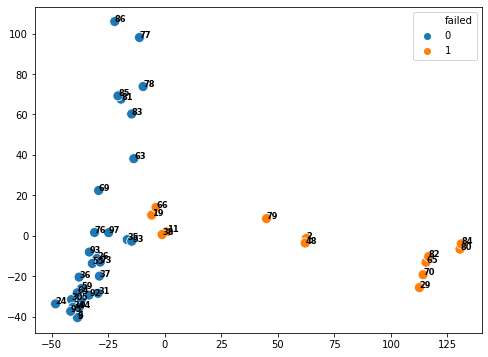

In [147]:
fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = failed.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        failed.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

### Modelling

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
C = [1, 0.75, 0.5, 0.25, .1, 0.075, 0.05, 0.025, .01]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(x, y)
    print('C:', c)
    print('Total features with 0 coeff:', np.sum(clf.coef_ == 0))
    print('Training accuracy:', clf.score(x, y))
    print('')

C: 1
Total features with 0 coeff: 23275
Training accuracy: 1.0

C: 0.75
Total features with 0 coeff: 23400
Training accuracy: 1.0

C: 0.5
Total features with 0 coeff: 23730
Training accuracy: 1.0

C: 0.25
Total features with 0 coeff: 23784
Training accuracy: 1.0

C: 0.1
Total features with 0 coeff: 23790
Training accuracy: 1.0

C: 0.075
Total features with 0 coeff: 23849
Training accuracy: 1.0

C: 0.05
Total features with 0 coeff: 23837
Training accuracy: 1.0

C: 0.025
Total features with 0 coeff: 23885
Training accuracy: 1.0

C: 0.01
Total features with 0 coeff: 23955
Training accuracy: 1.0



In [21]:
clf = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')

clf.fit(x, y)
print('Total features with 0 coeff:', np.sum(clf.coef_ == 0))
print('Training accuracy:', clf.score(x, y))
    
feat_imp = pd.DataFrame(x.columns)
feat_imp['coef'] = clf.coef_.reshape(clf.coef_.shape[1],1)

feat_imp = feat_imp[feat_imp.coef != 0]
feat_imp['abs_coef'] = np.abs(feat_imp.coef)
feat_imp = feat_imp.sort_values('abs_coef', ascending= False)

print(confusion_matrix(clf.predict(x), y))

Total features with 0 coeff: 23949
Training accuracy: 1.0
[[30  0]
 [ 0 13]]


In [22]:
feat_imp

,variable,coef,abs_coef
15452,"power_mean__fft_coefficient__coeff_3__attr_""real""",8.379550e-05,8.379550e-05
15495,"power_mean__fft_coefficient__coeff_4__attr_""imag""",6.033553e-05,6.033553e-05
15539,"power_mean__fft_coefficient__coeff_5__attr_""imag""",4.606539e-05,4.606539e-05
15716,"power_mean__fft_coefficient__coeff_9__attr_""real""",3.270468e-05,3.270468e-05
15540,"power_mean__fft_coefficient__coeff_5__attr_""real""",-2.599809e-05,2.599809e-05
...,...,...,...
15172,power_mean__abs_energy,-2.937348e-10,2.937348e-10
14604,power_max__c3__lag_2,2.295210e-10,2.295210e-10
14539,power_max__abs_energy,-1.941667e-10,1.941667e-10
14605,power_max__c3__lag_3,1.509284e-10,1.509284e-10


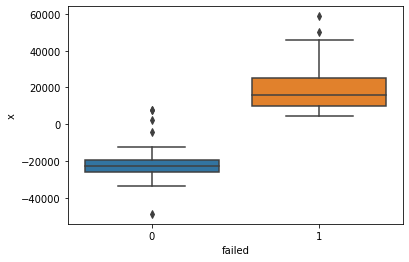

In [23]:
var = 'power_mean__fft_coefficient__coeff_3__attr_"real"'

temp_df = pd.DataFrame(feat_df[var].values, columns = ["x"])
temp_df['failed'] = failed.failed

sns.boxplot(x = temp_df.failed, y = temp_df.x)

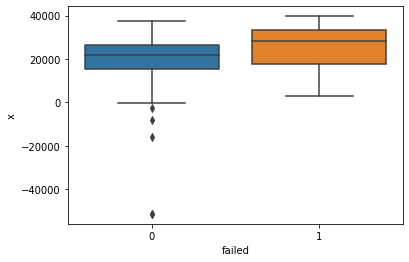

In [24]:
var = 'power_mean__fft_coefficient__coeff_4__attr_"imag"'

temp_df = pd.DataFrame(feat_df[var].values, columns = ["x"])
temp_df['failed'] = failed.failed

sns.boxplot(x = temp_df.failed, y = temp_df.x)

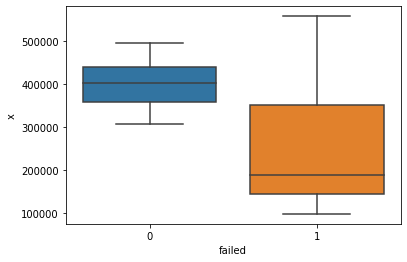

In [102]:
var = 'rotor_speed_kurtosis__abs_energy'

temp_df = pd.DataFrame(feat_df[var].values, columns = ["x"])
temp_df['failed'] = failed.failed

sns.boxplot(x = temp_df.failed, y = temp_df.x)

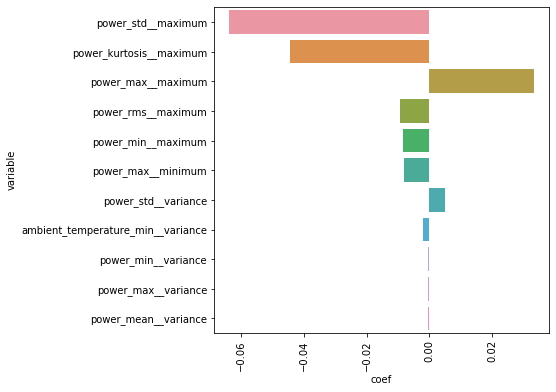

In [278]:
fig, ax = plt.subplots(figsize = (6, 6))
sns.barplot(y = feat_imp.variable, x = feat_imp.coef)
ax.xaxis.set_tick_params(rotation=90)

### Stratified K-sampling

In [25]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_ix, test_ix in kfold.split(x, y):
    train_x, test_x = x.iloc[train_ix], x.iloc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

    clf = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
    clf.fit(train_x, train_y)
    print('Fold 1:')
    print('Training Score:', clf.score(train_x, train_y))
    print('Testing Score:', clf.score(test_x, test_y))
    print(confusion_matrix(test_y, clf.predict(test_x)))
    print('')

Fold 1:
Training Score: 1.0
Testing Score: 0.8888888888888888
[[5 1]
 [0 3]]

Fold 1:
Training Score: 1.0
Testing Score: 0.6666666666666666
[[5 1]
 [2 1]]

Fold 1:
Training Score: 1.0
Testing Score: 0.8888888888888888
[[6 0]
 [1 2]]

Fold 1:
Training Score: 1.0
Testing Score: 1.0
[[6 0]
 [0 2]]

Fold 1:
Training Score: 1.0
Testing Score: 1.0
[[6 0]
 [0 2]]



[Text(167.4, 163.07999999999998, 'X[23531] <= 0.093\ngini = 0.422\nsamples = 43\nvalue = [30, 13]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 30\nvalue = [30, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]')]

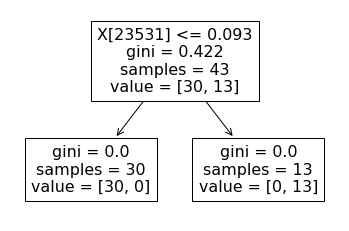

In [26]:
clf = tree.DecisionTreeClassifier(max_depth = 2, splitter = "best")
tree.plot_tree(clf.fit(x, y)) 

In [117]:
feats = []

for i, col in enumerate(x.columns):
    clf = tree.DecisionTreeClassifier(max_depth = 1, splitter = "best")
    clf.fit(x.iloc[:,i:i+1], y)
    if clf.tree_.impurity[1] == 0 and clf.tree_.impurity[2] == 0:
        feats.append(col)

In [118]:
len(feats)

9

In [119]:
feats

['ambient_temperature_max__quantile__q_0.6',
 'ambient_temperature_max__quantile__q_0.7',
 'ambient_temperature_mean__quantile__q_0.7',
 'ambient_temperature_min__fft_coefficient__coeff_5__attr_"angle"',
 'nacelle_temperature_max__fft_coefficient__coeff_2__attr_"real"',
 'nacelle_temperature_mean__fft_coefficient__coeff_2__attr_"real"',
 'nacelle_temperature_min__fft_coefficient__coeff_2__attr_"real"',
 'nacelle_temperature_rms__fft_coefficient__coeff_2__attr_"real"',
 'power_min__median']

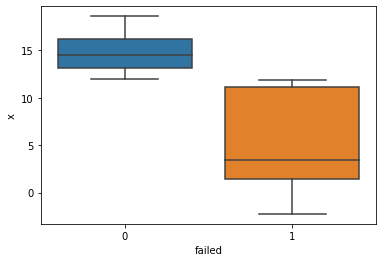

In [123]:
var = 'power_min__median'

temp_df = pd.DataFrame(feat_df[var].values, columns = ["x"])
temp_df['failed'] = failed.failed

sns.boxplot(x = temp_df.failed, y = temp_df.x)

## Non-Dimensionalized Data

In [148]:
def prep_df3(turbine_ids):
    
    failure = pd.DataFrame(columns = ['turbine_id', 'failed'])
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/nondimensionalized/*_" + str(i) + "_*.feather")[0])
        
        shutdowns = list(failures['Shutdown.Date'][failures.ID == i])
        
        shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
        if(pd.notnull(shutdown_date)):
            temp_df = temp_df[temp_df.Date <= shutdown_date]
            failure = failure.append({'turbine_id': i, 'failed':1}, True)
        else:
            temp_df = temp_df[temp_df.Date <= pd.to_datetime("10-01-2013")]
            failure = failure.append({'turbine_id': i, 'failed':0}, True)
            
        df = df.append(temp_df)

    df = df.reset_index(drop = True)

    return df, failure

In [149]:
turbines.remove(65)

In [150]:
df3, failed3 = prep_df3(turbines)

In [151]:
df3.head()

,Date,Turbine_ID,Failed.Before,A_rollerload_max_N_mean_hss,B_rollerload_max_N_mean_hss,A_Load_N_mean_hss,B_Load_N_mean_hss,A_Energy_J_mean_hss,B_Energy_J_mean_hss,Shaft_Speed_rpm_mean_hss,...,nacelle_temperature_mean,power_sd,rotor_speed_sd,wind_speed_sd,wind_direction_10_sec_sd,wind_direction_1_sec_sd,gearbox_oil_temperature_sd,gearbox_bearing_temperature_sd,ambient_temperature_sd,nacelle_temperature_sd
0,2008-12-01,2,0.0,0.173103,0.097360,0.484688,0.369968,4.881063,7.836017,1.004619,...,14.151552,395.056823,3.332425,2.112489,6.931841,6.903993,3.160071,4.997739,3.379863,2.976744
1,2008-12-02,2,0.0,0.152254,0.085637,0.426311,0.325422,6.915496,10.353597,0.974752,...,24.767327,378.499334,2.516045,1.788269,3.570594,3.581710,5.156140,6.011102,2.084695,2.584279
2,2008-12-03,2,0.0,0.340283,0.191361,0.952793,0.727173,8.173234,5.448261,1.068124,...,16.007857,114.619552,0.942526,2.351553,4.027963,4.031374,3.461533,4.769525,3.230817,1.701399
3,2008-12-04,2,0.0,0.144345,0.081190,0.404165,0.308522,5.214163,8.963494,0.978542,...,8.803779,329.205906,2.644072,1.761770,4.621249,4.661481,0.594925,1.962658,2.474008,3.734821
4,2008-12-05,2,0.0,0.139769,0.078617,0.391353,0.298745,6.600366,10.417597,0.925355,...,9.509656,346.931946,6.653666,3.499385,6.844031,6.727570,6.185227,9.724780,4.590759,4.017372


In [152]:
df3.shape

(64730, 183)

In [153]:
failed3.head()

,turbine_id,failed
0,2,1
1,11,1
2,19,1
3,29,1
4,38,1


In [154]:
list(df3.columns)

['Date',
 'Turbine_ID',
 'Failed.Before',
 'A_rollerload_max_N_mean_hss',
 'B_rollerload_max_N_mean_hss',
 'A_Load_N_mean_hss',
 'B_Load_N_mean_hss',
 'A_Energy_J_mean_hss',
 'B_Energy_J_mean_hss',
 'Shaft_Speed_rpm_mean_hss',
 'A_SlipDensity_mean_hss',
 'B_SlipDensity_mean_hss',
 'A_cagespeed_rpm_mean_hss',
 'B_cagespeed_rpm_mean_hss',
 'A_Roller_Deflec_max_mm_mean_hss',
 'B_Roller_Deflec_max_mm_mean_hss',
 'A_Roller_Speed_max_mps_mean_hss',
 'B_Roller_Speed_max_mps_mean_hss',
 'A_Sliding_Speed_max_mps_mean_hss',
 'B_Sliding_Speed_max_mps_mean_hss',
 'A_SRR_max_mean_hss',
 'B_SRR_max_mean_hss',
 'A_rollerload_max_N_sd_hss',
 'B_rollerload_max_N_sd_hss',
 'A_Load_N_sd_hss',
 'B_Load_N_sd_hss',
 'A_Energy_J_sd_hss',
 'B_Energy_J_sd_hss',
 'Shaft_Speed_rpm_sd_hss',
 'A_SlipDensity_sd_hss',
 'B_SlipDensity_sd_hss',
 'A_cagespeed_rpm_sd_hss',
 'B_cagespeed_rpm_sd_hss',
 'A_Roller_Deflec_max_mm_sd_hss',
 'B_Roller_Deflec_max_mm_sd_hss',
 'A_Roller_Speed_max_mps_sd_hss',
 'B_Roller_Speed_max

In [155]:
df3.fillna(df3.mean(), inplace = True)

In [156]:
failed3 = failed3.sort_values('turbine_id').reset_index(drop= True)

In [157]:
df3.drop(['Failed.Before', 'Time_min_hss', 'Time_min_ims', 'A_Energy_cumsum_J_ims',\
         'A_Energy_cumsum_J_hss', 'B_Energy_cumsum_J_ims', 'B_Energy_cumsum_J_hss'], axis = 1, inplace = True)

In [158]:
feat_df3 = extract_features(df3, column_id="Turbine_ID", column_sort="Date", \
                            default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


In [159]:
feat_df3.shape

(42, 1392)

In [160]:
feat_df3.head()

variable,A_Energy_J_max_hss__length,A_Energy_J_max_hss__maximum,A_Energy_J_max_hss__mean,A_Energy_J_max_hss__median,A_Energy_J_max_hss__minimum,A_Energy_J_max_hss__standard_deviation,A_Energy_J_max_hss__sum_values,A_Energy_J_max_hss__variance,A_Energy_J_max_ims__length,A_Energy_J_max_ims__maximum,...,wind_speed_mean__sum_values,wind_speed_mean__variance,wind_speed_sd__length,wind_speed_sd__maximum,wind_speed_sd__mean,wind_speed_sd__median,wind_speed_sd__minimum,wind_speed_sd__standard_deviation,wind_speed_sd__sum_values,wind_speed_sd__variance
id,,,,,,,,,,,,,,,,,,,,,
2,1155.0,29.845296,12.902782,11.339550,3.376429,3.156525,14902.713311,9.963652,1155.0,1.596560,...,9213.306120,5.394627,1155.0,7.231309,2.266830,2.193844,0.049497,0.818869,2618.188356,0.670547
3,1735.0,20.315425,12.925963,11.383930,4.167736,2.981165,22426.545734,8.887345,1735.0,1.304129,...,13735.473453,5.683120,1735.0,6.614315,2.346070,2.254202,0.253112,0.858611,4070.431761,0.737213
5,1732.0,21.534173,12.918166,11.388877,2.989042,3.081686,22374.263561,9.496790,1732.0,1.389121,...,14397.623537,5.082281,1732.0,6.052897,2.273283,2.207182,0.275789,0.797456,3937.326781,0.635936
6,1746.0,33.998720,12.996455,11.364937,3.008219,3.113560,22691.810600,9.694257,1746.0,1.521185,...,14162.546041,5.313496,1746.0,6.430018,2.248021,2.189162,0.258347,0.789121,3925.044271,0.622712
11,1599.0,27.154210,12.760857,11.327754,3.168371,3.068452,20404.610812,9.415395,1599.0,1.392518,...,13067.146251,5.262606,1599.0,6.165580,2.241291,2.153493,0.349112,0.789152,3583.823651,0.622760


In [161]:
feat_df3.tail()

variable,A_Energy_J_max_hss__length,A_Energy_J_max_hss__maximum,A_Energy_J_max_hss__mean,A_Energy_J_max_hss__median,A_Energy_J_max_hss__minimum,A_Energy_J_max_hss__standard_deviation,A_Energy_J_max_hss__sum_values,A_Energy_J_max_hss__variance,A_Energy_J_max_ims__length,A_Energy_J_max_ims__maximum,...,wind_speed_mean__sum_values,wind_speed_mean__variance,wind_speed_sd__length,wind_speed_sd__maximum,wind_speed_sd__mean,wind_speed_sd__median,wind_speed_sd__minimum,wind_speed_sd__standard_deviation,wind_speed_sd__sum_values,wind_speed_sd__variance
id,,,,,,,,,,,,,,,,,,,,,
92,1726.0,21.798168,12.876257,11.392932,3.091423,3.029794,22224.419198,9.179649,1726.0,1.299499,...,13823.229574,5.978373,1726.0,5.731314,2.266577,2.196448,0.159386,0.811506,3912.112048,0.658542
93,1726.0,37.793362,12.887699,11.397892,3.272215,3.135654,22244.168408,9.832324,1726.0,1.278390,...,13668.106420,5.540959,1726.0,5.418929,2.141334,2.093455,0.036694,0.804947,3695.942377,0.647940
94,1731.0,33.943979,13.009336,11.374087,3.238556,3.094096,22519.159920,9.573433,1731.0,1.387944,...,14242.824586,5.598347,1731.0,5.355648,2.245748,2.171476,0.258873,0.793125,3887.389213,0.629047
95,1729.0,41.643528,13.008934,11.399977,4.178176,3.035832,22492.446275,9.216276,1729.0,1.343994,...,14184.202862,5.691705,1729.0,5.425904,2.244139,2.155204,0.194388,0.789331,3880.116626,0.623044
97,1705.0,32.896011,12.738101,11.327265,4.468789,2.946321,21718.461375,8.680806,1705.0,1.428239,...,14188.894140,5.855829,1705.0,5.523442,2.303073,2.221049,0.184594,0.818159,3926.738718,0.669384


In [162]:
feat_df3.isnull().any().any()

False

In [163]:
cols = feat_df3.columns
cols = [x for x in cols if '__sum_values' not in x]
cols = [x for x in cols if '__length' not in x]

In [164]:
len(cols)

1044

In [165]:
x = feat_df3[cols]
x.shape

(42, 1044)

In [166]:
y = failed3.failed

In [167]:
y.shape

(42,)

In [168]:
y = y.astype('int')

### Plots

#### Energy

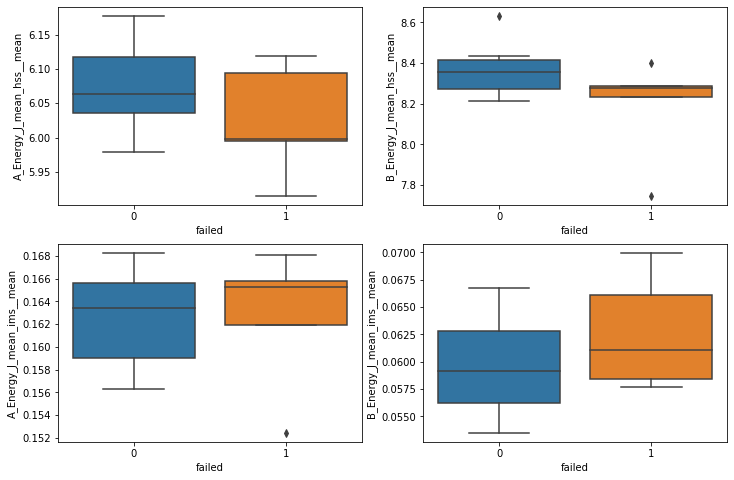

In [178]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
sns.boxplot(x = y, y = x.A_Energy_J_mean_hss__mean, ax= ax[0,0])
sns.boxplot(x = y, y = x.B_Energy_J_mean_hss__mean, ax= ax[0,1])
sns.boxplot(x = y, y = x.A_Energy_J_mean_ims__mean, ax= ax[1,0])
sns.boxplot(x = y, y = x.B_Energy_J_mean_ims__mean, ax= ax[1,1])

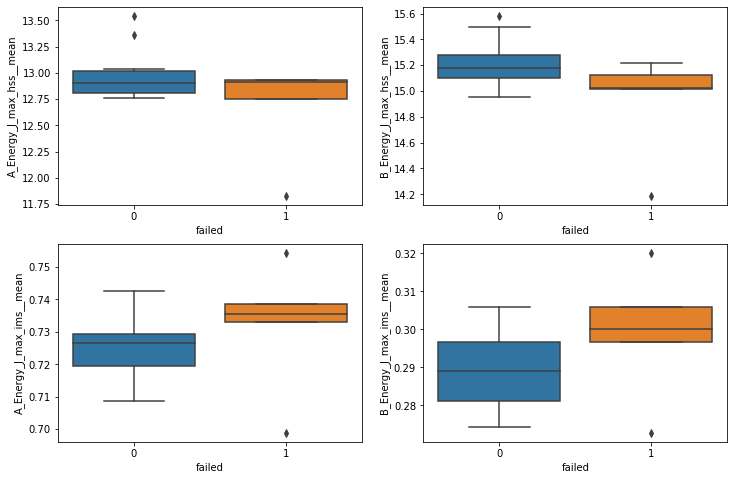

In [174]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
sns.boxplot(x = y, y = x.A_Energy_J_max_hss__mean, ax= ax[0,0])
sns.boxplot(x = y, y = x.B_Energy_J_max_hss__mean, ax= ax[0,1])
sns.boxplot(x = y, y = x.A_Energy_J_max_ims__mean, ax= ax[1,0])
sns.boxplot(x = y, y = x.B_Energy_J_max_ims__mean, ax= ax[1,1])

#### Slip Density

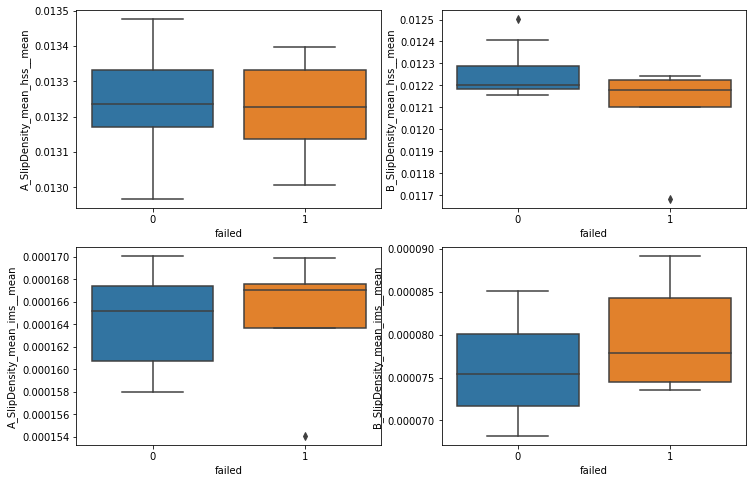

In [177]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
sns.boxplot(x = y, y = x.A_SlipDensity_mean_hss__mean, ax= ax[0,0])
sns.boxplot(x = y, y = x.B_SlipDensity_mean_hss__mean, ax= ax[0,1])
sns.boxplot(x = y, y = x.A_SlipDensity_mean_ims__mean, ax= ax[1,0])
sns.boxplot(x = y, y = x.B_SlipDensity_mean_ims__mean, ax= ax[1,1])

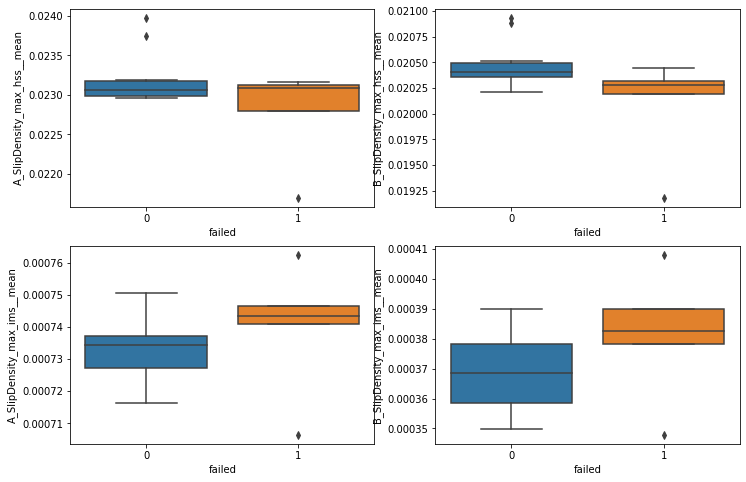

In [179]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
sns.boxplot(x = y, y = x.A_SlipDensity_max_hss__mean, ax= ax[0,0])
sns.boxplot(x = y, y = x.B_SlipDensity_max_hss__mean, ax= ax[0,1])
sns.boxplot(x = y, y = x.A_SlipDensity_max_ims__mean, ax= ax[1,0])
sns.boxplot(x = y, y = x.B_SlipDensity_max_ims__mean, ax= ax[1,1])

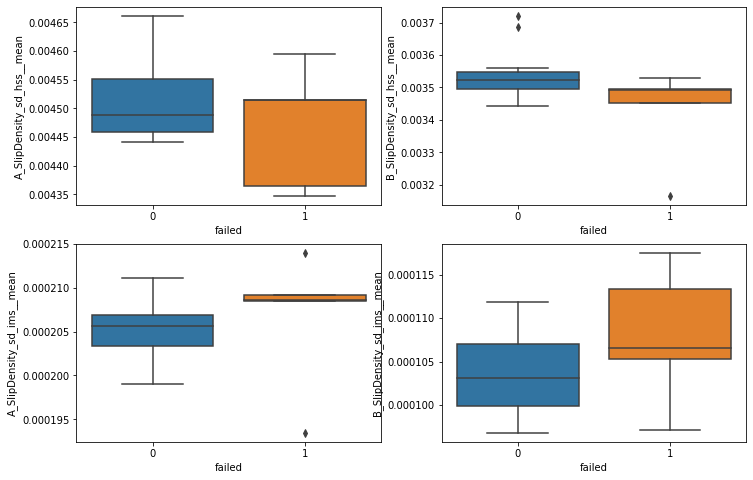

In [180]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
sns.boxplot(x = y, y = x.A_SlipDensity_sd_hss__mean, ax= ax[0,0])
sns.boxplot(x = y, y = x.B_SlipDensity_sd_hss__mean, ax= ax[0,1])
sns.boxplot(x = y, y = x.A_SlipDensity_sd_ims__mean, ax= ax[1,0])
sns.boxplot(x = y, y = x.B_SlipDensity_sd_ims__mean, ax= ax[1,1])

In [183]:
C = [1, 0.75, 0.5, 0.25, .1, 0.075, 0.05, 0.025, .01]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(x, y)
    print('C:', c)
    print('Total features with 0 coeff:', np.sum(clf.coef_ == 0))
    print('Training accuracy:', clf.score(x, y))
    print('')

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C: 1
Total features with 0 coeff: 1016
Training accuracy: 1.0



/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C: 0.75
Total features with 0 coeff: 1020
Training accuracy: 1.0



/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C: 0.5
Total features with 0 coeff: 1023
Training accuracy: 1.0



/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C: 0.25
Total features with 0 coeff: 1022
Training accuracy: 1.0



/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C: 0.1
Total features with 0 coeff: 1031
Training accuracy: 0.9761904761904762

C: 0.075
Total features with 0 coeff: 1032
Training accuracy: 0.9761904761904762

C: 0.05
Total features with 0 coeff: 1034
Training accuracy: 0.9761904761904762

C: 0.025
Total features with 0 coeff: 1035
Training accuracy: 0.9285714285714286

C: 0.01
Total features with 0 coeff: 1037
Training accuracy: 0.8333333333333334



In [184]:
clf = LogisticRegression(penalty='l1', C=0.05, solver='liblinear')

clf.fit(x, y)
print('Total features with 0 coeff:', np.sum(clf.coef_ == 0))
print('Training accuracy:', clf.score(x, y))
    
feat_imp = pd.DataFrame(x.columns)
feat_imp['coef'] = clf.coef_.reshape(clf.coef_.shape[1],1)

feat_imp = feat_imp[feat_imp.coef != 0]
feat_imp['abs_coef'] = np.abs(feat_imp.coef)
feat_imp = feat_imp.sort_values('abs_coef', ascending= False)

print(confusion_matrix(clf.predict(x), y))

Total features with 0 coeff: 1034
Training accuracy: 0.9761904761904762
[[30  1]
 [ 0 11]]


In [185]:
feat_imp

,variable,coef,abs_coef
986,power_mean__median,0.055720,0.055720
990,power_sd__maximum,-0.041292,0.041292
659,B_SRR_max_min_ims__variance,-0.032005,0.032005
197,A_SRR_max_max_hss__variance,-0.026407,0.026407
912,ambient_temperature_mean__maximum,0.013874,0.013874
918,ambient_temperature_sd__maximum,-0.013163,0.013163
984,power_mean__maximum,0.013140,0.013140
995,power_sd__variance,0.002229,0.002229
989,power_mean__variance,-0.000407,0.000407
917,ambient_temperature_mean__variance,-0.000405,0.000405


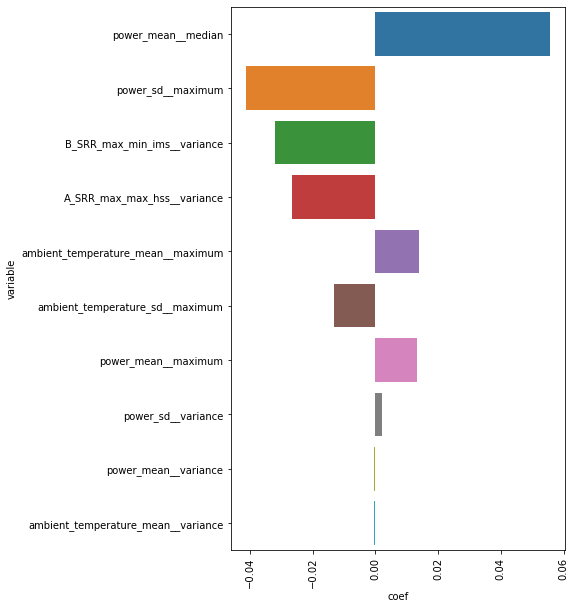

In [186]:
fig, ax = plt.subplots(figsize = (6, 10))
sns.barplot(y = feat_imp.variable, x = feat_imp.coef)
ax.xaxis.set_tick_params(rotation=90)

In [187]:
preds = pd.DataFrame(clf.predict_proba(x))
preds['True'] = y
preds['predicted'] = clf.predict(x)
preds['turbine_id'] = failed.turbine_id
preds

,0,1,True,predicted,turbine_id
0,0.037400,0.962600,1,1,2
1,0.842719,0.157281,0,0,3
2,0.813419,0.186581,0,0,5
3,0.933136,0.066864,0,0,6
4,0.486296,0.513704,1,1,11
5,0.164172,0.835828,1,1,19
6,0.715112,0.284888,0,0,24
7,0.727415,0.272585,0,0,26
8,0.003127,0.996873,1,1,29
9,0.985132,0.014868,0,0,30


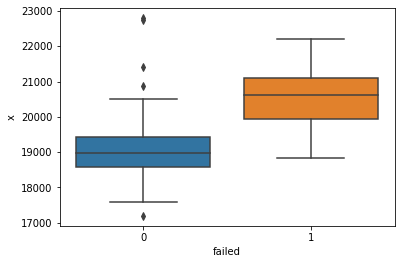

In [188]:
var = 'power_sd__variance'

temp_df = pd.DataFrame(feat_df3[var].values, columns = ["x"])
temp_df['failed'] = failed3.failed

sns.boxplot(x = temp_df.failed, y = temp_df.x)

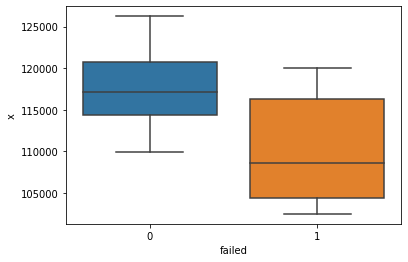

In [189]:
var = 'power_mean__variance'

temp_df = pd.DataFrame(feat_df3[var].values, columns = ["x"])
temp_df['failed'] = failed3.failed

sns.boxplot(x = temp_df.failed, y = temp_df.x)

### Decision Tree

In [190]:
from sklearn import tree

In [191]:
feats = []

for i, col in enumerate(x.columns):
    clf = tree.DecisionTreeClassifier(max_depth = 1, splitter = "best")
    clf.fit(x.iloc[:,i:i+1], y)
    if len(clf.tree_.impurity) == 3:
        if clf.tree_.impurity[1] == 0 and clf.tree_.impurity[2] == 0:
            feats.append(col)

feats

[]

[Text(133.92000000000002, 181.2, 'X[913] <= 18.698\ngini = 0.408\nsamples = 42\nvalue = [30, 12]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(200.88000000000002, 108.72, 'X[1004] <= 2.405\ngini = 0.117\nsamples = 32\nvalue = [30, 2]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 30\nvalue = [30, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

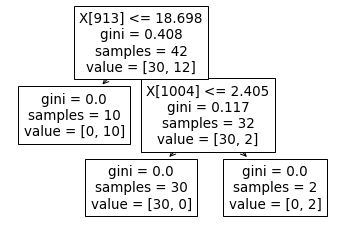

In [194]:
clf = tree.DecisionTreeClassifier(max_depth = 2, splitter = "best")
tree.plot_tree(clf.fit(x, y))

In [197]:
x.columns[1004]

'rotor_speed_sd__median'

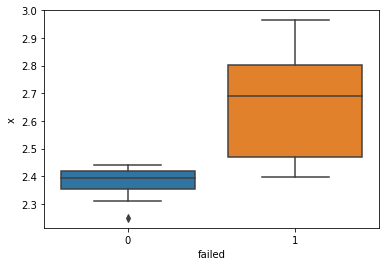

In [201]:
var = 'rotor_speed_sd__mean'

temp_df = pd.DataFrame(feat_df3[var].values, columns = ["x"])
temp_df['failed'] = failed3.failed

sns.boxplot(x = temp_df.failed, y = temp_df.x)